In [14]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import os
import torch
import torchvision
import torchvision.transforms.functional as fn
from PIL import Image
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 as cv

from src.data.car_plate_dataset import UFPRPlateDataset

In [2]:
os.chdir(r"C:/Users/Arya/workspace/ProjectSentry/data/raw/UFPR-ALPR dataset/testing/track0091")
os.getcwd()

'C:\\Users\\Arya\\workspace\\ProjectSentry\\data\\raw\\UFPR-ALPR dataset\\testing\\track0091'

In [3]:
# os.chdir(os.listdir(os.getcwd())[0])
im = Image.open("track0091[01].png")
np_im = np.array(im)

gS = torchvision.transforms.Grayscale()
resize = torchvision.transforms.Resize(size=540)
crop = torchvision.transforms.CenterCrop(size=400)


# print(np_im)
# im

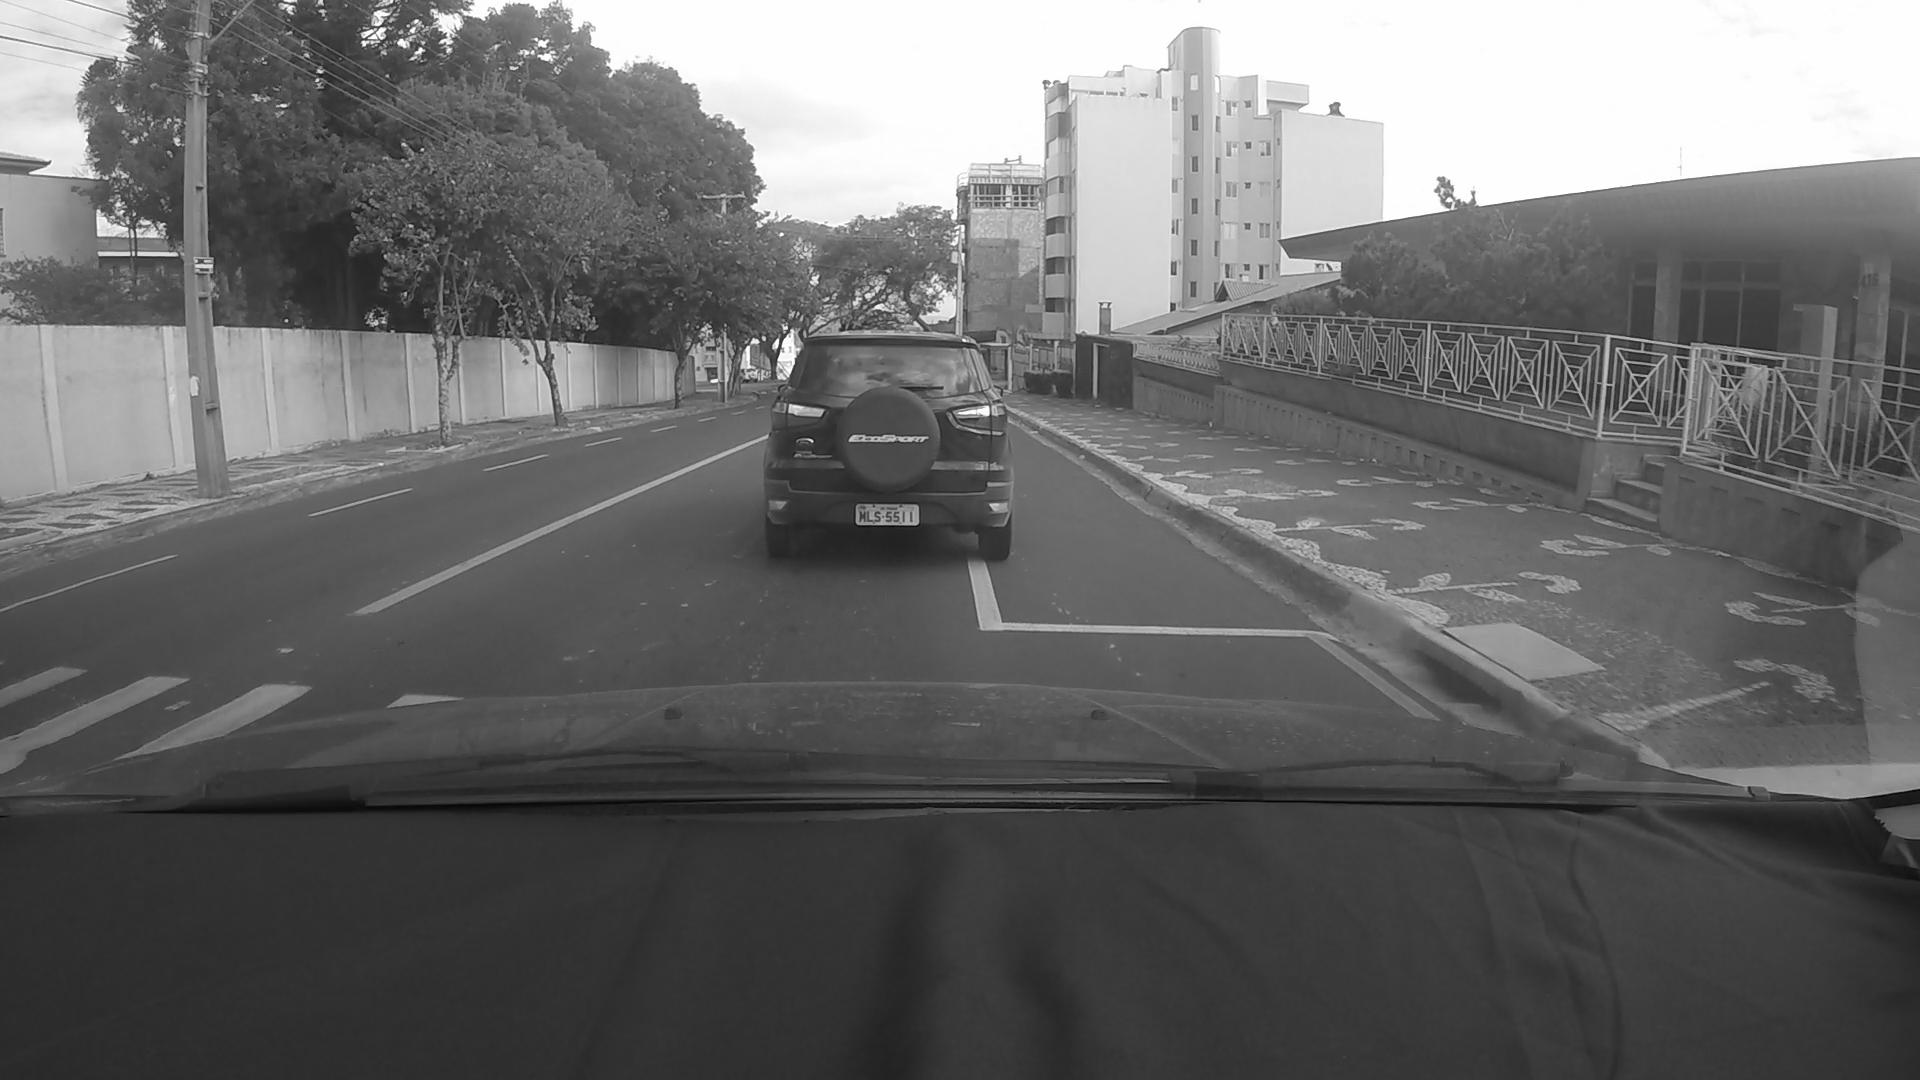

In [4]:
grey_im = gS(im)
grey_im

(400, 400)


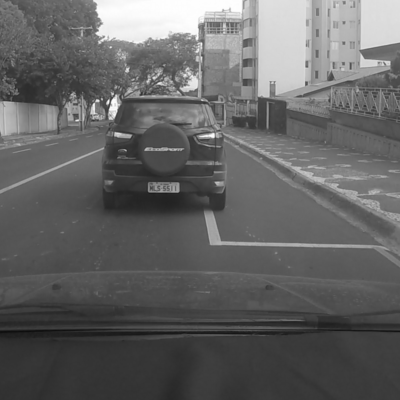

In [5]:
resized_and_grey = resize(grey_im)
cropped = crop(resized_and_grey)
print(cropped.size)
cropped

In [9]:
with open("track0091[01].txt", "r") as track0091_01_txt:
    txt = track0091_01_txt.readlines()

    lp = txt[6].replace("plate: ", "") # line 6 in the txt has licence plate number
    plate = txt[7] # line 7 has bounding box location for licence plate

    plate = ''.join(i for i in plate if i.isdigit() or i == " ")
    temp_list = [int(i) for i in plate.replace(" ", "", 1).split(" ")]
    # plate_date = (x_min, y_min, x_max, y_max)
    plate_data = (temp_list[0], temp_list[1], temp_list[0] + temp_list[2], temp_list[1] + temp_list[3])

print(list(lp)[:-1])
print(plate_data)

['M', 'L', 'S', '-', '5', '5', '1', '1']
(855, 504, 919, 525)


In [7]:
fig, ax = plt.subplots()

# plt.imshow(cv.cvtColor(cv.imread("track0091[01].png"), cv.COLOR_BGR2RGB))
plt.imshow(np.asarray(grey_im), cmap='gray')

rect = patches.Rectangle((855, 504), 64, 21, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
# print(rect.get_corners())

plt.show()

<IPython.core.display.Javascript object>

In [38]:
dataset = UFPRPlateDataset("C:\\Users\\Arya\\workspace\\ProjectSentry\\data\\raw\\UFPR-ALPR dataset")

{'testing': 'C:\\Users\\Arya\\workspace\\ProjectSentry\\data\\raw\\UFPR-ALPR dataset\\testing', 'training': 'C:\\Users\\Arya\\workspace\\ProjectSentry\\data\\raw\\UFPR-ALPR dataset\\training', 'validation': 'C:\\Users\\Arya\\workspace\\ProjectSentry\\data\\raw\\UFPR-ALPR dataset\\validation'}
C:\Users\Arya\workspace\ProjectSentry\data\raw\UFPR-ALPR dataset\training\track0001\track0001[01].txt
C:\Users\Arya\workspace\ProjectSentry\data\raw\UFPR-ALPR dataset\training\track0001\track0001[01].txt
C:\Users\Arya\workspace\ProjectSentry\data\raw\UFPR-ALPR dataset\training\track0001\track0001[02].txt
C:\Users\Arya\workspace\ProjectSentry\data\raw\UFPR-ALPR dataset\training\track0001\track0001[02].txt
C:\Users\Arya\workspace\ProjectSentry\data\raw\UFPR-ALPR dataset\training\track0001\track0001[03].txt
C:\Users\Arya\workspace\ProjectSentry\data\raw\UFPR-ALPR dataset\training\track0001\track0001[03].txt
C:\Users\Arya\workspace\ProjectSentry\data\raw\UFPR-ALPR dataset\training\track0001\track0001[

ValueError: invalid literal for int() with base 10: ''